# Notebook 1: ML Pipeline Exploration

This tutorial builds a training and testing pipeline for a toy ML prediction problem: to predict whether a passenger in a NYC taxicab ride will give the driver a nontrivial tip. This is a binary classification task. A nontrivial tip is arbitrarily defined as greater than 10% of the total fare (before tip). To evaluate the model or measure the efficacy of the model, we measure the accuracy. 

In this notebook, we will put together an ML pipeline. We:

1. Train a model on data from January 2020
2. Simulate deployment by running inference on a weekly basis from February 1, 2020 to May 31, 2020
3. Experience a significant performance decrease in our pipeline (from 83% F1 score to below 70%)

## Setup

* Create a new environment with Python 3.8 or later
* Navigate to the root and download the requirements by running `pip install -r requirements.txt` in your terminal
* Open jupyter by running `jupyter-lab` in your terminal or opening the notebook in an editor of your choice (e.g., VSCode)

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from datetime import date, timedelta
from pipeline import components

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Parameters

We use the yellow taxicab trip records from the NYC Taxi & Limousine Comission [public dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), which is stored in a public aws S3 bucket. The data dictionary can be found [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

We train on January 2020 data and simulate weekly inference / make predictions from February 1 to May 31, 2020. We use features from the data dictionary.

In [14]:
# PARAMETERS
train_start_date = date(2020, 1, 1)
train_end_date = date(2020, 1, 31)
inference_start_date = date(2020, 2, 1)
inference_end_date = date(2020, 5, 31)
cadence = 7

feature_columns = [
    "pickup_weekday",
    "pickup_hour",
    "pickup_minute",
    "work_hours",
    "passenger_count",
    "trip_distance",
    "trip_speed",
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
    "congestion_surcharge",
    "loc_code_diffs",
]
label_column = "high_tip_indicator"

### Training and Inference

In `pipeline/components.py`, we have defined and implemented functions as part of a pipeline. The training component trains a RandomForestClassifier on the data.

TODO(shreyashankar): insert diagram of pipeline here

In [17]:
# TRAINING

# Clean and featurize data
df = components.load_data(train_start_date, train_end_date)
clean_df = components.clean_data(df, train_start_date, train_end_date)
features_df = components.featurize_data(clean_df)

# Train model
train_df, test_df = components.train_test_split(features_df)
components.train_model(train_df, test_df, feature_columns, label_column)

Train scores:
{'accuracy_score': 0.7054597321103382, 'f1_score': 0.8178915586866272, 'precision_score': 0.7060820570520019, 'recall_score': 0.97177389219552}
Test scores:
{'accuracy_score': 0.7247045609922844, 'f1_score': 0.8328267477203647, 'precision_score': 0.727088367276493, 'recall_score': 0.9745532357874038}
                 feature  importance
0   congestion_surcharge    0.400641
1        passenger_count    0.247575
2             RatecodeID    0.126707
3          trip_distance    0.089810
4             trip_speed    0.053967
5           PULocationID    0.040370
6            pickup_hour    0.018170
7           DOLocationID    0.013338
8         loc_code_diffs    0.007130
9         pickup_weekday    0.002013
10            work_hours    0.000153
11         pickup_minute    0.000125


In [39]:
# INFERENCE

results = {}
prev_dt = inference_start_date
for n in range(7, int((inference_end_date - inference_start_date).days) + 1, 7):
    curr_dt = inference_start_date + timedelta(n)
    df = components.load_data(prev_dt, curr_dt)
    clean_df = components.clean_data(df, prev_dt, curr_dt)
    features_df = components.featurize_data(clean_df)
    _, scores = components.inference(features_df, feature_columns, label_column)
    results[prev_dt] = scores
    prev_dt = curr_dt

result_df = pd.DataFrame(results).T.reset_index(drop=False)
result_df.rename(columns={"index": "date"}, inplace=True)

In [41]:
result_df

,date,accuracy_score,f1_score,precision_score,recall_score
0,2020-02-01,0.726665,0.834569,0.730602,0.973035
1,2020-02-08,0.722608,0.831636,0.726005,0.973239
2,2020-02-15,0.698885,0.814283,0.701183,0.970885
3,2020-02-22,0.723812,0.832028,0.727006,0.972515
4,2020-02-29,0.703033,0.816664,0.705343,0.969708
5,2020-03-07,0.720005,0.827943,0.721591,0.971065
6,2020-03-14,0.671821,0.783312,0.663323,0.956296
7,2020-03-21,0.616871,0.722146,0.585481,0.942042
8,2020-03-28,0.603936,0.705667,0.566190,0.936325
9,2020-04-04,0.601176,0.699201,0.570326,0.903324


### Results

Here we plot the accuracy and F1 scores over time.

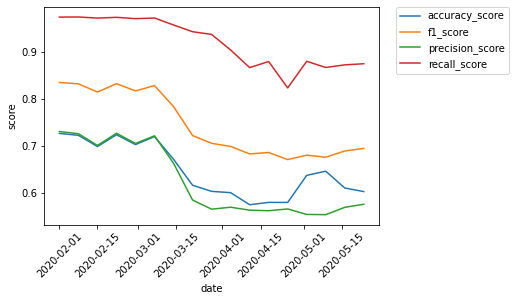

In [54]:
# PLOTTING

result_plot_df = result_df.melt(id_vars=["date"], var_name="metric", value_name="score")
sns.lineplot(x="date", y="score", hue="metric", data=result_plot_df)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Exercises

1. Currently, we are only tracking accuracy and F1 scores. In the `score` function in `pipeline/components.py`, add code to track precision and recall.
2. Regenerate the plot above with all 4 metrics.
3. Investigate the plot -- for example, take a look where metrics drop (around COVID-19). Note the nature of metric changes over time.
4. Do some exploratory data analysis (EDA) on the data from February 1, 2020 to May 31, 2020. Plot the number of data points per week. Regenerate the metric plots with a 1 or 2-day cadence instead of a 7-day cadence. Note what you observe.